In [1]:
#Tratamieto de datos
import pandas as pd 
import numpy as np  
# ==============================================================================================================================================================

#   Gráficos 
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
# ==============================================================================================================================================================

#Procesado y Modelado
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
# ==============================================================================================================================================================

# Configuración matplotlib
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
# Configuración warnings
# ==============================================================================================================================================================

#Configuración warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_excel(r"D:\Never Urueta\2023\Algoritmos Tesis\Data.xlsx") 

In [3]:
data1 = data.drop(["PBA", "CF", "Indicador", "DESTINO", "CAPACIDAD DEL CUARTO FRIO  "], axis=1)

In [4]:
data1["Rechazados_%"] = data["Rechazados"] / data1["Canales"]
data1["Rechazados_Binario"] = data1["Rechazados"] 
data1["Rechazados_Multiclass"] = data1["Rechazados"] 
data1.loc[data1["Rechazados_Binario"] > 0, "Rechazados_Binario"] = 1
data1.loc[data1["Rechazados_Multiclass"] > 2, "Rechazados_Multiclass"] = 3
print(data1.Rechazados.value_counts().sort_index())
print(data1.Rechazados_Binario.value_counts().sort_index())
print(data1.Rechazados_Multiclass.value_counts().sort_index())

0    1329
1     222
2     263
3      93
4       5
5       2
Name: Rechazados, dtype: int64
0    1329
1     585
Name: Rechazados_Binario, dtype: int64
0    1329
1     222
2     263
3     100
Name: Rechazados_Multiclass, dtype: int64


# Umbral de Clasificación Esperado
En el 69.4% de las maduraciones No se rechazan canales y en el 30.6% sí se rechazan. Un modelo de clasificación que sea útil debe de ser capaz de predecir correctamente un porcentaje de observaciones por encima del porcentaje de la clase mayoritaria. En este caso, el umbral de referencia que se tiene que superar es del 69.4%.

In [5]:
###VARIABLES CATEGORICAS Y NUMERICAS
features = list(set(data1.columns.values) - set(['ID', 'TARGET']))
cat_features = [feat for feat in features if data1[feat].dtype.name in ['category', 'object']]
num_features = list(set(features) - set(cat_features))

print(f"Factores Categoricos: \n {cat_features}")
print(f"Factores Numéricos: \n {num_features}")

Factores Categoricos: 
 ['TIPO_CAP_CF', 'Refrigeracion', 'Franja2', 'Franja1', 'pH_Requisito', 'Dia_Semana']
Factores Numéricos: 
 ['Temp3', 'VT2', 'Ocupacion', 'Ti1', 'Temp1', 'Canales', 'VT1', 'Rechazados_Multiclass', 'Rechazados_Binario', 'Tamin', 'Ti2', 'Rechazados_%', 'Temp2', 'PPPCF', 'Rechazados', 'Taamax']


In [6]:
data1.isnull().sum() #Datos faltantes

Dia_Semana                0
Temp1                     0
Franja1                   0
Temp2                     0
Franja2                   0
VT1                       0
Ti1                       0
Temp3                     0
Ti2                       0
VT2                       0
Refrigeracion             0
Canales                   0
PPPCF                     0
Ocupacion                 0
pH_Requisito              0
Tamin                    29
Taamax                   29
TIPO_CAP_CF               0
Rechazados                0
Rechazados_%              0
Rechazados_Binario        0
Rechazados_Multiclass     0
dtype: int64

In [7]:
data1['Tamin'].fillna(data1['Tamin'].median(), inplace=True)
print("valores perdidos en Tamin: " + 
      str(data1['Tamin'].isnull().sum()))
data1['Taamax'].fillna(data1['Taamax'].median(), inplace=True)
print("valores perdidos en Taamax: " + 
      str(data1['Taamax'].isnull().sum()))

valores perdidos en Tamin: 0
valores perdidos en Taamax: 0


In [8]:
data1.describe()

,Temp1,Temp2,VT1,Ti1,Temp3,Ti2,VT2,Canales,PPPCF,Ocupacion,Tamin,Taamax,Rechazados,Rechazados_%,Rechazados_Binario,Rechazados_Multiclass
count,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000
mean,3.080371,11.733454,8.653083,2.129855,2.766437,33.368273,-8.955836,136.827586,22.518286,93.083697,23.857913,32.530543,0.552247,0.004139,0.305643,0.547544
std,1.614204,3.365969,3.251896,1.135182,1.774718,14.483894,3.597810,30.208935,15.420267,11.038884,0.960839,1.664524,0.930765,0.007340,0.460799,0.914589
min,-4.700000,1.400000,-3.200000,0.166667,-5.600000,24.000000,-35.200000,27.000000,3.991370,19.354839,20.400000,27.200000,0.000000,0.000000,0.000000,0.000000
25%,2.100000,10.000000,6.800000,1.583333,2.000000,24.250000,-10.900000,140.000000,17.022934,91.888046,23.300000,31.600000,0.000000,0.000000,0.000000,0.000000
50%,2.900000,11.500000,8.500000,1.883333,3.000000,25.250000,-9.000000,150.000000,19.326683,96.774194,24.000000,32.600000,0.000000,0.000000,0.000000,0.000000
75%,3.900000,13.800000,10.500000,2.483333,3.800000,37.757500,-7.000000,155.000000,23.219814,100.000000,24.500000,33.600000,1.000000,0.006667,1.000000,1.000000
max,18.200000,39.400000,36.800000,16.183333,7.300000,110.200000,4.200000,239.000000,100.000000,104.761905,26.000000,36.300000,5.000000,0.066667,1.000000,3.000000


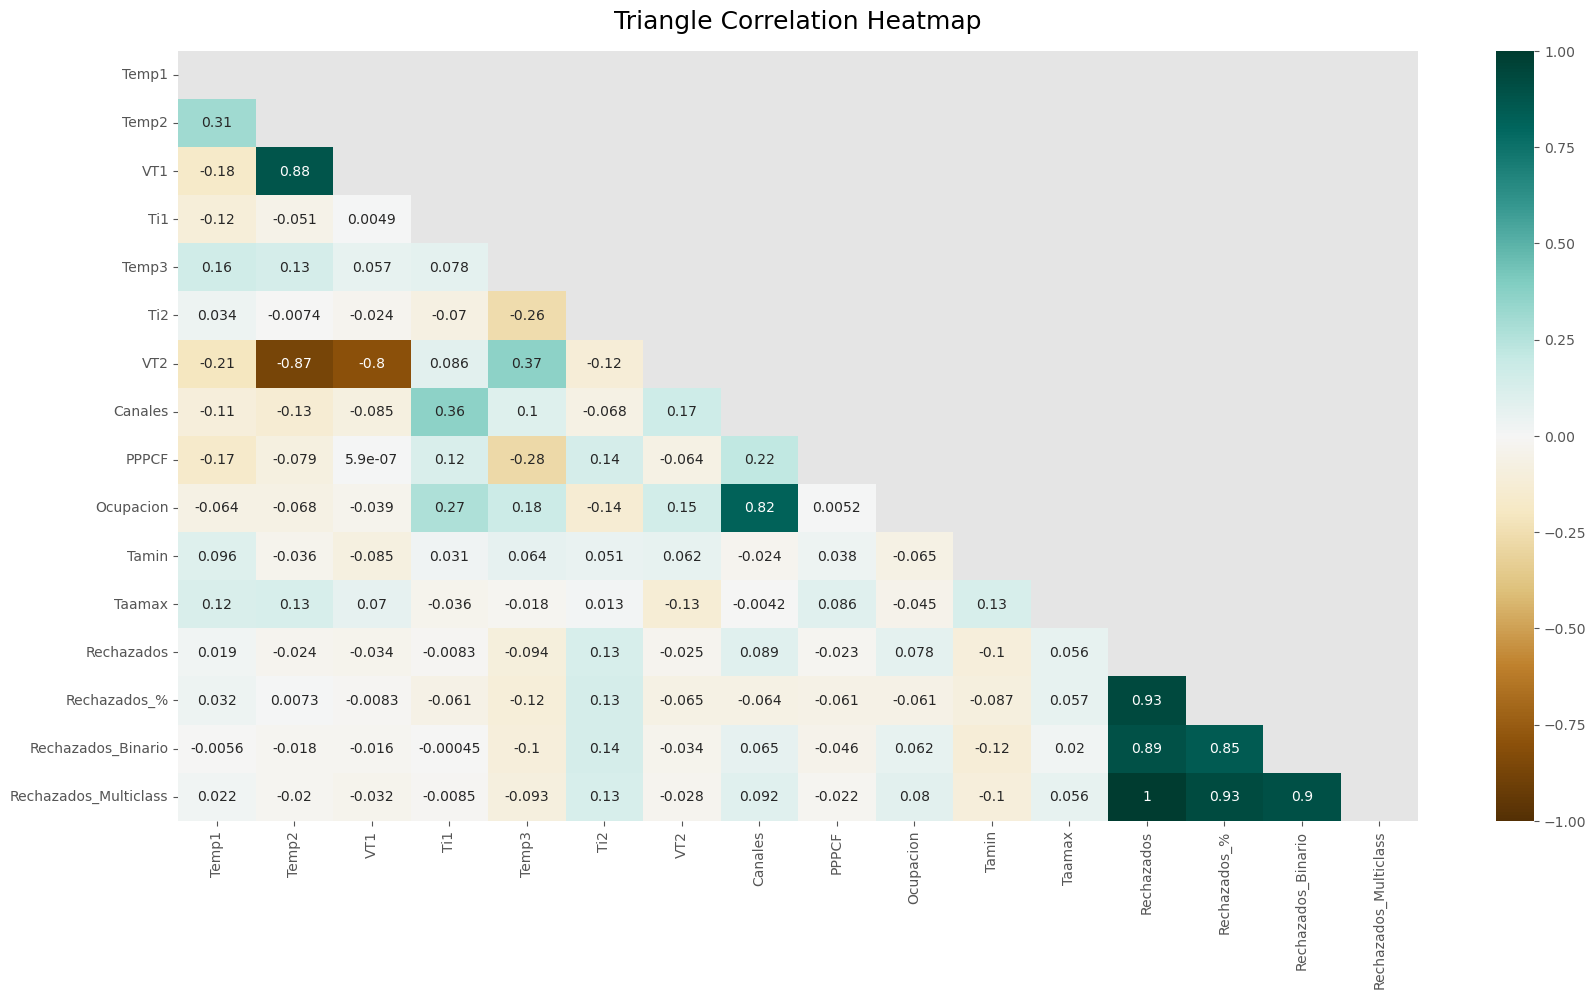

In [9]:
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(data1.corr(), dtype=np.bool))
heatmap = sns.heatmap(data1.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);
plt.show()

In [1]:
data1 = pd.get_dummies(data1, drop_first = True, columns = ["Franja1", "Franja2", "Dia_Semana"]) # el parámetro drop first la primera categoría, para evitar problemas de multicolinealidad
data1 = pd.get_dummies(data1, columns = ["Refrigeracion", "pH_Requisito", "TIPO_CAP_CF"]) 

NameError: name 'pd' is not defined

In [11]:
data1.columns

Index(['Temp1', 'Temp2', 'VT1', 'Ti1', 'Temp3', 'Ti2', 'VT2', 'Canales',
       'PPPCF', 'Ocupacion', 'Tamin', 'Taamax', 'Rechazados', 'Rechazados_%',
       'Rechazados_Binario', 'Rechazados_Multiclass', 'Franja1_MAÑANA',
       'Franja1_MEDIO_DIA', 'Franja1_NOCHE', 'Franja1_TARDE', 'Franja2_MAÑANA',
       'Franja2_MEDIO_DIA', 'Franja2_NOCHE', 'Franja2_TARDE',
       'Dia_Semana_lunes', 'Dia_Semana_martes', 'Dia_Semana_miércoles',
       'Dia_Semana_sábado', 'Dia_Semana_viernes', 'Refrigeracion_AMONIACO',
       'Refrigeracion_GLICOL', 'pH_Requisito_Mi_5.8', 'pH_Requisito_Mi_6',
       'TIPO_CAP_CF_C1', 'TIPO_CAP_CF_C2', 'TIPO_CAP_CF_C3',
       'TIPO_CAP_CF_PBA2'],
      dtype='object')

In [12]:
X_i = data1.drop(["Rechazados", "Rechazados_%", "Rechazados_Binario", "Rechazados_Multiclass"], axis=1)
Y = data1["Rechazados_Binario"]
X_i = sm.add_constant(X_i)
modelo=sm.Logit(Y,X_i)
modelo=modelo.fit()
modelo.summary()

         Current function value: 0.562275
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Rechazados_Binario   No. Observations:                 1914
Model:                          Logit   Df Residuals:                     1884
Method:                           MLE   Df Model:                           29
Date:                Thu, 11 May 2023   Pseudo R-squ.:                 0.08658
Time:                        16:00:12   Log-Likelihood:                -1076.2
converged:                      False   LL-Null:                       -1178.2
Covariance Type:            nonrobust   LLR p-value:                 3.261e-28
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.4581        nan        nan        nan         nan         nan
Temp1                     -0.0691        nan        nan        nan         nan         nan
Temp2                     -0.1019        nan        nan        nan         nan         nan
VT1                       -0.0329        nan        nan        nan         nan         nan
Ti1                       -0.0290      0.060     -0.484      0.628      -0.146       0.088
Temp3                     -0.0150      0.226     -0.066      0.947      -0.459       0.429
Ti2                        0.0241      0.004      5.878      0.000       0.016       0.032
VT2                       -0.1313      0.224     -0.585      0.558      -0.571       0.308
Canales                    0.0031      0.015      0.210      0.834      -0.026       0.032
PPPCF                      0.0143      0.009      1.617      0.106      -0.003       0.032
Ocupacion                  0.0033      0.021      0.156      0.876      -0.038       0.045
Tamin                     -0.3110      0.056     -5.560      0.000      -0.421      -0.201
Taamax                     0.0666      0.033      2.021      0.043       0.002       0.131
Franja1_MAÑANA            -0.6346      0.905     -0.701      0.483      -2.409       1.140
Franja1_MEDIO_DIA         -0.4780      0.887     -0.539      0.590      -2.217       1.261
Franja1_NOCHE             -0.6814      0.864     -0.788      0.431      -2.376       1.013
Franja1_TARDE             -0.6639      0.877     -0.757      0.449      -2.382       1.054
Franja2_MAÑANA            -0.8764      0.589     -1.489      0.137      -2.030       0.278
Franja2_MEDIO_DIA         -0.7439      0.563     -1.322      0.186      -1.847       0.359
Franja2_NOCHE             -0.6828      0.462     -1.479      0.139      -1.588       0.222
Franja2_TARDE             -0.4800      0.486     -0.988      0.323      -1.432       0.472
Dia_Semana_lunes           0.2882      0.186      1.552      0.121      -0.076       0.652
Dia_Semana_martes          0.2598      0.178      1.460      0.144      -0.089       0.609
Dia_Semana_miércoles       0.2269      0.178      1.275      0.202      -0.122       0.576
Dia_Semana_sábado         -0.2277      0.189     -1.207      0.227      -0.597       0.142
Dia_Semana_viernes        -0.4260      0.196     -2.174      0.030      -0.810      -0.042
Refrigeracion_AMONIACO     0.7920        nan        nan        nan         nan         nan
Refrigeracion_GLICOL       0.6661        nan        nan        nan         nan         nan
pH_Requisito_Mi_5.8        0.9469    1.7e+06   5.57e-07      1.000   -3.33e+06    3.33e+06
pH_Requisito_Mi_6          0.5111    1.7e+06   3.01e-07      1.000   -3.33e+06    3.33e+06
TIPO_CAP_CF_C1             1.3238        nan        nan        nan         nan         nan
TIPO_CAP_CF_C2             1.4959        nan        nan        nan         nan         nan
TIPO_CAP_CF_C3             1.3954        nan        nan 

In [13]:
#Multicolinealidad - VIFs
pd.Series([variance_inflation_factor(X_i, i) 
               for i in range(X_i.shape[1])], 
              index=X_i.columns)              

const                       0.000000
Temp1                            inf
Temp2                            inf
VT1                              inf
Ti1                         1.509510
Temp3                      36.884787
Ti2                         1.314546
VT2                       147.189294
Canales                    17.402246
PPPCF                       4.679912
Ocupacion                   6.382065
Tamin                       1.071543
Taamax                      1.091219
Franja1_MAÑANA             61.412655
Franja1_MEDIO_DIA          43.568365
Franja1_NOCHE              31.781134
Franja1_TARDE              69.302845
Franja2_MAÑANA              9.986006
Franja2_MEDIO_DIA          16.099672
Franja2_NOCHE              14.954815
Franja2_TARDE              20.909991
Dia_Semana_lunes            1.699796
Dia_Semana_martes           1.711895
Dia_Semana_miércoles        1.716614
Dia_Semana_sábado           1.794986
Dia_Semana_viernes          1.757810
Refrigeracion_AMONIACO           inf
R

In [14]:
data1.columns

Index(['Temp1', 'Temp2', 'VT1', 'Ti1', 'Temp3', 'Ti2', 'VT2', 'Canales',
       'PPPCF', 'Ocupacion', 'Tamin', 'Taamax', 'Rechazados', 'Rechazados_%',
       'Rechazados_Binario', 'Rechazados_Multiclass', 'Franja1_MAÑANA',
       'Franja1_MEDIO_DIA', 'Franja1_NOCHE', 'Franja1_TARDE', 'Franja2_MAÑANA',
       'Franja2_MEDIO_DIA', 'Franja2_NOCHE', 'Franja2_TARDE',
       'Dia_Semana_lunes', 'Dia_Semana_martes', 'Dia_Semana_miércoles',
       'Dia_Semana_sábado', 'Dia_Semana_viernes', 'Refrigeracion_AMONIACO',
       'Refrigeracion_GLICOL', 'pH_Requisito_Mi_5.8', 'pH_Requisito_Mi_6',
       'TIPO_CAP_CF_C1', 'TIPO_CAP_CF_C2', 'TIPO_CAP_CF_C3',
       'TIPO_CAP_CF_PBA2'],
      dtype='object')

In [15]:
#Eliminando la Multicolinealidad
X_i_Post = X_i.drop(["VT1","VT2", "VT2", "Franja1_MAÑANA", "Franja1_MEDIO_DIA","Franja1_NOCHE", "Franja1_TARDE","Refrigeracion_GLICOL", "pH_Requisito_Mi_6", "Franja2_TARDE", "Canales", "TIPO_CAP_CF_PBA2","TIPO_CAP_CF_C1", "TIPO_CAP_CF_C2", "TIPO_CAP_CF_C3", "TIPO_CAP_CF_PBA2"], axis=1)

In [16]:
pd.Series([variance_inflation_factor(X_i_Post, i) 
               for i in range(X_i_Post.shape[1])], 
              index=X_i_Post.columns)        

const                     1069.462375
Temp1                        1.213085
Temp2                        1.238243
Ti1                          1.156226
Temp3                        1.245937
Ti2                          1.238265
PPPCF                        1.381588
Ocupacion                    1.275319
Tamin                        1.062183
Taamax                       1.077072
Franja2_MAÑANA               1.166571
Franja2_MEDIO_DIA            1.216856
Franja2_NOCHE                1.217808
Dia_Semana_lunes             1.691873
Dia_Semana_martes            1.702116
Dia_Semana_miércoles         1.710005
Dia_Semana_sábado            1.759589
Dia_Semana_viernes           1.744054
Refrigeracion_AMONIACO       1.308906
pH_Requisito_Mi_5.8          1.134676
dtype: float64

In [17]:
#Nuevo modelo
model=sm.Logit(Y,X_i_Post)
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.571664
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Rechazados_Binario   No. Observations:                 1914
Model:                          Logit   Df Residuals:                     1894
Method:                           MLE   Df Model:                           19
Date:                Thu, 11 May 2023   Pseudo R-squ.:                 0.07133
Time:                        16:00:46   Log-Likelihood:                -1094.2
converged:                       True   LL-Null:                       -1178.2
Covariance Type:            nonrobust   LLR p-value:                 6.770e-26
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.7326      1.710      1.013      0.311      -1.618       5.084
Temp1                  -9.437e-05      0.036     -0.003      0.998      -0.071       0.071
Temp2                     -0.0093      0.017     -0.535      0.593      -0.043       0.025
Ti1                       -0.0078      0.051     -0.153      0.879      -0.108       0.093
Temp3                     -0.1228      0.032     -3.834      0.000      -0.186      -0.060
Ti2                        0.0288      0.004      7.193      0.000       0.021       0.037
PPPCF                     -0.0154      0.005     -3.215      0.001      -0.025      -0.006
Ocupacion                  0.0187      0.006      3.180      0.001       0.007       0.030
Tamin                     -0.2862      0.055     -5.181      0.000      -0.394      -0.178
Taamax                     0.0609      0.032      1.876      0.061      -0.003       0.125
Franja2_MAÑANA            -0.4607      0.199     -2.319      0.020      -0.850      -0.071
Franja2_MEDIO_DIA         -0.3289      0.150     -2.187      0.029      -0.624      -0.034
Franja2_NOCHE             -0.3450      0.132     -2.618      0.009      -0.603      -0.087
Dia_Semana_lunes           0.2591      0.184      1.408      0.159      -0.101       0.620
Dia_Semana_martes          0.2651      0.176      1.503      0.133      -0.081       0.611
Dia_Semana_miércoles       0.2194      0.177      1.243      0.214      -0.127       0.566
Dia_Semana_sábado         -0.3265      0.187     -1.747      0.081      -0.693       0.040
Dia_Semana_viernes        -0.4732      0.195     -2.424      0.015      -0.856      -0.091
Refrigeracion_AMONIACO     0.2141      0.119      1.795      0.073      -0.020       0.448
pH_Requisito_Mi_5.8        0.5464      0.130      4.203      0.000       0.292       0.801
==========================================================================================
"""

In [19]:
#Solo Variables significativas
X_i_Reducido = X_i_Post.loc[:,["Temp3","Ti2", "PPPCF", "Ocupacion", "Tamin", "Franja2_MAÑANA","Franja2_MEDIO_DIA", "Franja2_NOCHE", "pH_Requisito_Mi_5.8","Dia_Semana_viernes"]]
X_i_Reducido = sm.add_constant(X_i_Reducido)
model_Red=sm.Logit(Y,X_i_Reducido)
result_Red=model_Red.fit()
result_Red.summary()

Optimization terminated successfully.
         Current function value: 0.577389
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Rechazados_Binario   No. Observations:                 1914
Model:                          Logit   Df Residuals:                     1903
Method:                           MLE   Df Model:                           10
Date:                Thu, 11 May 2023   Pseudo R-squ.:                 0.06203
Time:                        16:02:42   Log-Likelihood:                -1105.1
converged:                       True   LL-Null:                       -1178.2
Covariance Type:            nonrobust   LLR p-value:                 2.298e-26
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.2201      1.392      2.313      0.021       0.492       5.948
Temp3                  -0.1260      0.031     -4.029      0.000      -0.187      -0.065
Ti2                     0.0241      0.004      6.473      0.000       0.017       0.031
PPPCF                  -0.0119      0.004     -2.682      0.007      -0.021      -0.003
Ocupacion               0.0200      0.006      3.599      0.000       0.009       0.031
Tamin                  -0.2640      0.053     -4.943      0.000      -0.369      -0.159
Franja2_MAÑANA         -0.4191      0.192     -2.182      0.029      -0.795      -0.043
Franja2_MEDIO_DIA      -0.2990      0.146     -2.044      0.041      -0.586      -0.012
Franja2_NOCHE          -0.3515      0.130     -2.696      0.007      -0.607      -0.096
pH_Requisito_Mi_5.8     0.5608      0.129      4.347      0.000       0.308       0.814
Dia_Semana_viernes     -0.5040      0.154     -3.280      0.001      -0.805      -0.203
=======================================================================================
"""

### Se presenta las ecuaciones en el modelo 

## Interpretación de los resultados: Odds Ratio, Intervalos de Confianza y Pvalues

In [20]:
params = np.exp(result_Red.params)
conf = np.exp(result_Red.conf_int())
conf['OR'] = params
pvalue=round(result_Red.pvalues,3)
conf['pvalue']=pvalue
conf.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
print ((conf))

                     CI 95%(2.5%)  CI 95%(97.5%)  Odds Ratio  pvalue
const                    1.635527     383.042774   25.029522   0.021
Temp3                    0.829175       0.937331    0.881596   0.000
Ti2                      1.016966       1.031936    1.024424   0.000
PPPCF                    0.979551       0.996790    0.988133   0.007
Ocupacion                1.009130       1.031309    1.020159   0.000
Tamin                    0.691661       0.852720    0.767980   0.000
Franja2_MAÑANA           0.451358       0.958241    0.657655   0.029
Franja2_MEDIO_DIA        0.556741       0.987717    0.741554   0.041
Franja2_NOCHE            0.544921       0.908479    0.703598   0.007
pH_Requisito_Mi_5.8      1.360610       2.256042    1.752026   0.000
Dia_Semana_viernes       0.447051       0.816425    0.604139   0.001


In [21]:
# Dividimos los conjuntos de prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X_i_Reducido, Y, train_size=0.8, random_state=1234)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [22]:
#Entrenamosel modelo y obtenemos accuracy
logit_model= sm.Logit(y_train, X_train)

# Accuracy

In [23]:
result= logit_model.fit_regularized()
accuracy = accuracy_score(y_true = y_test, y_pred = np.where(result.predict(X_test) <0.5, 0, 1), normalize = True)
print("")
print(f"Accuracy: {100*accuracy}%")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.580877642526483
            Iterations: 52
            Function evaluations: 60
            Gradient evaluations: 52

Accuracy: 70.49608355091384%


El modelo logra clasificar correctamente el 70,5% de las observaciones, el umbral esperado es del 69,4%; po lo tanto; es un modelo adecuedo de clasificación. 

# Matriz de Confusión

Una matriz de confusión es una herramienta para resumir el rendimiento de un algoritmo de clasificación. Una matriz de confusión nos dará una imagen clara del rendimiento del modelo de clasificación y los tipos de errores producidos por el modelo. Nos da un resumen de predicciones correctas e incorrectas desglosadas por cada categoría. El resumen se representa en forma tabular.


- Verdaderos positivos (TP): los verdaderos positivos ocurren cuando predecimos que una observación pertenece a una determinada clase y la observación en realidad pertenece a esa clase.

- Verdaderos negativos (TN): los verdaderos negativos ocurren cuando predecimos que una observación no pertenece a una determinada clase y la observación en realidad no pertenece a esa clase.

- Falsos positivos (FP): los falsos positivos ocurren cuando predecimos que una observación pertenece a una determinada clase, pero la observación en realidad no pertenece a esa clase. Este tipo de error se denomina error tipo I.

- Falsos negativos (FN): los falsos negativos ocurren cuando predecimos que una observación no pertenece a una determinada clase, pero la observación en realidad pertenece a esa clase. Este es un error muy grave y se llama error de tipo II.

<AxesSubplot:>

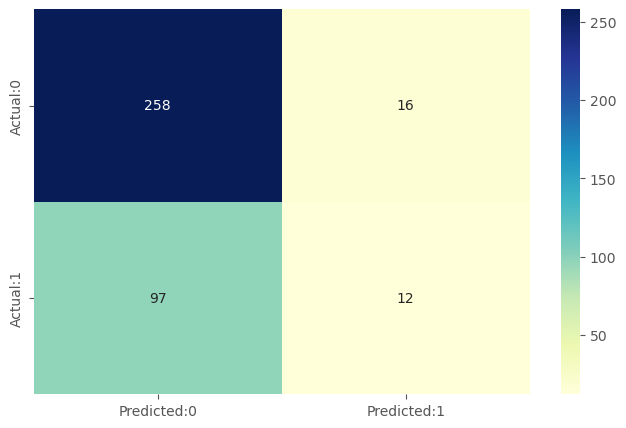

In [25]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,np.where(result.predict(X_test) <0.5, 0, 1))
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

> La Matriz de Confusión muestra 258 + 12 = 270 predicciones correctas y 97 + 16 = 113 predicciones incorrectas.

>>  - Verdaderos Positivos : 12
>>  - Verdaderos Negativos: 258
>>  - Falsos Positivos: 16 (Error Tipo 1) 
>>  - Falsos Negativos: 97 (Error Tipo 2) 

In [26]:
TN = cm[0,0]
TP = cm[1,1]
FN = cm[1,0]
FP = cm[0,1] 
Sencibilidad = TP/float(TP+FN)
Especificidad = TN/float(TN+FP)

# Evaluación del Modelo - Estadísticas

In [27]:
print('La acuuracy (Exactitud) of the del modelo es = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',

'La clasificación errónea = 1 - Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',

'Sensibilidad o tasa de verdaderos positivos = TP/(TP+FN) = ',TP/float(TP+FN),'\n',

'especificidad o tasa verdaderos negativos = TN/(TN+FP) = ',TN/float(TN+FP),'\n',

'Valor predictivo positivo = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

'Valor predictivo negativo = TN/(TN+FN) = ',TN/float(TN+FN),'\n',

'Razón de verosimilitud positiva (Likelihood Ratio) = Sencibilidad/(1-Especificidad) = ',Sencibilidad/(1-Especificidad),'\n',

'Razón de verosimilitud negativa (likelihood Ratio) = (1-Sencibilidad)/Especificidad) = ',(1-Sencibilidad)/Especificidad) 

La acuuracy (Exactitud) of the del modelo es = TP+TN/(TP+TN+FP+FN) =  0.7049608355091384 
 La clasificación errónea = 1 - Accuracy =  0.29503916449086165 
 Sensibilidad o tasa de verdaderos positivos = TP/(TP+FN) =  0.11009174311926606 
 especificidad o tasa verdaderos negativos = TN/(TN+FP) =  0.9416058394160584 
 Valor predictivo positivo = TP/(TP+FP) =  0.42857142857142855 
 Valor predictivo negativo = TN/(TN+FN) =  0.7267605633802817 
 Razón de verosimilitud positiva (Likelihood Ratio) = Sencibilidad/(1-Especificidad) =  1.88532110091743 
 Razón de verosimilitud negativa (likelihood Ratio) = (1-Sencibilidad)/Especificidad) =  0.9450963658345779


<span style="color:magenta"> 
De las estadísticas anteriores, está claro que el modelo es más específico que sensible. Los valores negativos se predicen con mayor precisión que los positivos.</span>

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test, np.where(result.predict(X_test) <0.5, 0, 1)))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82       274
           1       0.43      0.11      0.18       109

    accuracy                           0.70       383
   macro avg       0.58      0.53      0.50       383
weighted avg       0.64      0.70      0.64       383



## Predicciones probabilísticas con Umbral 0.5
Miremos las probabilidades con un umbral de 0.5

In [29]:
Pred = result.predict(X_test)
Pred = pd.DataFrame(Pred, columns=['Prob de no rechazar canales (0)'])
Pred ['Prob de rechazar canales (1)'] = 1 - Pred 
Pred.head()

,Prob de no rechazar canales (0),Prob de rechazar canales (1)
1730,0.517143,0.482857
1831,0.539807,0.460193
362,0.294688,0.705312
1402,0.623904,0.376096
78,0.273068,0.726932


## Bajando el Umbral

In [30]:
logreg=LogisticRegression()
logreg.fit(X_train,y_train)

for i in range(5,8):
    cm2=0
    y_pred_prob_yes=logreg.predict_proba(X_test)
    y_pred2=binarize(y_pred_prob_yes, threshold = i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'The accuracy is ',(cm2[1,1]+cm2[0,0])/float(cm2[1,1]+cm2[0,0]+cm2[0,1]+cm2[1,0]),'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],'Type II errors( False Negatives)','\n',
          'Sensitivity: ',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity: ',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n',
          '=====================================================================', '\n')


With 0.5 threshold the Confusion Matrix is  
 [[263  11]
 [100   9]] 
 The accuracy is  0.7101827676240209 
 with 272 correct predictions and 100 Type II errors( False Negatives) 
 Sensitivity:  0.08256880733944955 Specificity:  0.9598540145985401 

With 0.6 threshold the Confusion Matrix is  
 [[269   5]
 [108   1]] 
 The accuracy is  0.7049608355091384 
 with 270 correct predictions and 108 Type II errors( False Negatives) 
 Sensitivity:  0.009174311926605505 Specificity:  0.9817518248175182 

With 0.7 threshold the Confusion Matrix is  
 [[273   1]
 [109   0]] 
 The accuracy is  0.7127937336814621 
 with 273 correct predictions and 109 Type II errors( False Negatives) 
 Sensitivity:  0.0 Specificity:  0.9963503649635036 



# Curva ROC

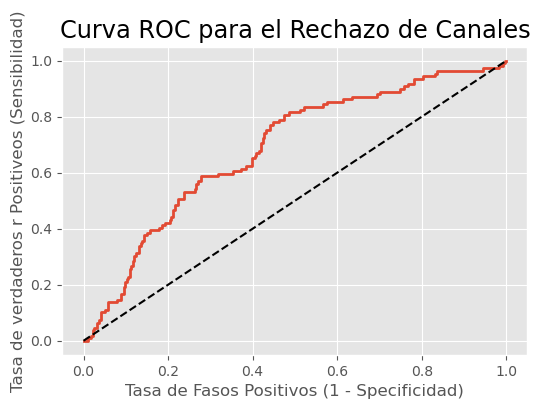

In [31]:
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_prob_yes[:,1])
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('Curva ROC para el Rechazo de Canales')
plt.xlabel('Tasa de Fasos Positivos (1 - Specificidad)')
plt.ylabel('Tasa de verdaderos r Positiveos (Sensibilidad)')
plt.show()

In [32]:
metrics.auc(fpr, tpr)

0.6870019420076342